In [17]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../src/")
sys.path.insert(0, "../projects/skimpy_bench/src/")
sys.path.insert(0, "../projects/skimpy_blox/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import math
import functools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import skimpy
import _skimpy_cpp_ext
import _skimpy_bench_cpp_ext
from skimpy import config as skimpy_config
from skimpy_bench import benchmarks
from skimpy_blox.minecraft import SkimpyMinecraftLevel

sns.set()

In [9]:
NUM_REPEATS = 1
BYTES_PER_INT = 4
MEGABYTES = 1024 * 1024
colors = sns.color_palette()

def log_2_elements_space(start_size, end_size, num):
    return np.logspace(math.log2(start_size), math.log2(end_size), base=2, num=num).astype(int)

def color_for_key(key):
    key = key.lower()
    if key.startswith("memory"):
        return colors[0]
    elif key.startswith("numpy"):
        return colors[1]
    elif key.startswith("torch"):
        return colors[2]
    elif key.startswith("taco"):
        return colors[3]
    elif key.startswith("skimpy"):
        return colors[4]
    else:
        offset = 5
        return colors[offset + hash(key) % (len(colors) - offset)]


def line_plot(
    xs,
    ys_dict,
    xlabel=None,
    ylabel=None,
    title=None,
    output_path=None,
    xlog=True,
    ylog=True,
):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for legend_name, v_dict in ys_dict.items():
        ax.plot(xs, v_dict["vals"], label=legend_name, linewidth=2, color=color_for_key(legend_name))
        
    if title:
        plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.1f}" if x < 1 else f"{x:.0f}"))
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    
    if output_path:
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
    plt.show()
    
    
def plot_bar(vals, title=None, xlabel=None, xlog=True, output_path=None, normed_labels=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    min_val = min(e["val"] for e in vals.values())

    for i, (legend_name, v_dict) in enumerate(sorted(vals.items(), key=lambda x: x[1]['val'], reverse=True)):
        val = v_dict["val"]
        ax.barh(legend_name, val, color=color_for_key(legend_name))
        ax.text(val + 5, i - 0.1, f"{val / min_val:.0f}x", color='black')

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if xlog:
        plt.xscale("log")
        
    plt.xlim(left=0)
        
        
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.1f}" if x < 1 else f"{x:.0f}"))
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    if output_path:
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
    plt.show()

FULL_SUITE = {
    "Skimpy (single-threaded)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1
        },
    },
    "Skimpy (multi-threaded)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    },
    "Taco": {
        "method": "run_taco",
    },
    "Torch": {
        "method": "run_torch",
    },
    "Numpy": {
        "method": "run_numpy"
    },
    "Memory": {
        "method": "run_memory",
    },
}

FULL_SUITE_WITH_CUSTOM_ADD = {
    "Skimpy (single-threaded compiled kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1,
            "use_custom_kernel": True,
        },   
    },
    "Skimpy (multi-threaded compiled kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32,
            "use_custom_kernel": True,
        },   
    },
    **FULL_SUITE,
}

SPARSE_SUITE = {
    "Skimpy (single-threaded)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1
        },
    },
    "Skimpy (single-threaded compiled kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1,
            "use_custom_kernel": True,
        },   
    },
    "Skimpy (multi-threaded)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    },
    "Skimpy (multi-threaded compiled kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32,
            "use_custom_kernel": True,
        },   
    },
    "Torch (sparse)": {
        "method": "run_torch",
        "kwargs": {
            "dense": False,
        }
    },
    "Torch (dense)": {
        "method": "run_torch",
        "kwargs": {
            "dense": True,
        }
    },
    "Taco": {
        "method": "run_taco",
    },
    "Numpy (Dense)": {
        "method": "run_numpy"
    },
    "Memory": {
        "method": "run_memory",
    },   
}
SPARSE_SUITE_NO_TACO = {k: v for k, v in SPARSE_SUITE.items() if k != "Taco"}

CONV_SUITE_WITH_GPU = {
    "Skimpy (single-threaded)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1
        },
    },
    "Skimpy (multi-threaded)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    }, 
    "Torch (cpu)": {
        "method": "run_torch",
    },
    "Torch (gpu)": {
        "method": "run_torch",
        "kwargs": {
            "device": "cuda:0",
        }
    },
}
CONV_SUITE_NO_GPU = {k: v for k, v in CONV_SUITE_WITH_GPU.items() if k != "Torch (gpu)"}
    

In [4]:
def dense_suite(num_inputs, array_lengths):
    return benchmarks.DenseArrayBenchmark.run_suite_axis(
        'array_length', array_lengths,
        repeats=NUM_REPEATS,
        num_inputs=num_inputs,
        suite=FULL_SUITE_WITH_CUSTOM_ADD,
    )

In [5]:
array_lengths = log_2_elements_space(256 // BYTES_PER_INT, 256 * MEGABYTES // BYTES_PER_INT, num=2)
four_way = dense_suite(num_inputs=4, array_lengths=array_lengths,)
sixteen_way = dense_suite(num_inputs=16, array_lengths=array_lengths,)

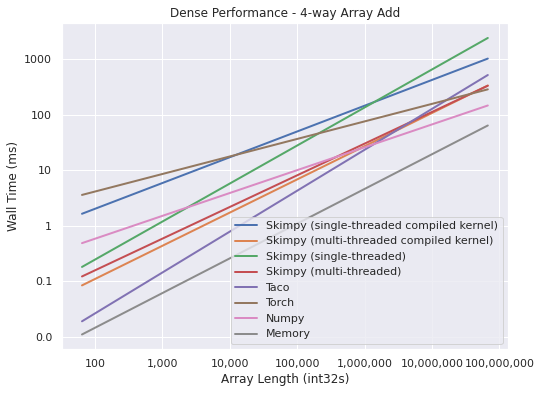

In [6]:
line_plot(
    array_lengths, 
    four_way, 
    xlabel="Array Length (int32s)", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 4-way Array Add",
)

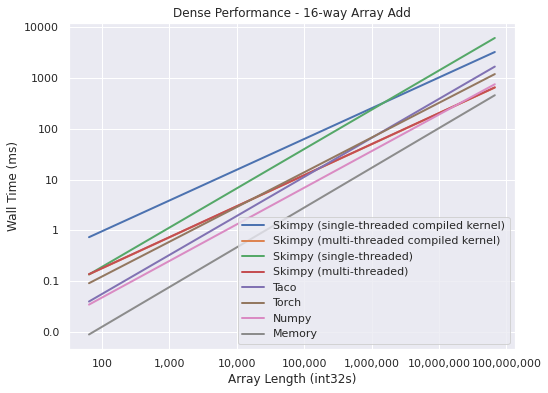

In [8]:
line_plot(
    array_lengths, 
    sixteen_way, 
    xlabel="Array Length (int32s)", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 16-way Array Add",
)

In [4]:
gigabyte_array_4 = benchmarks.DenseArrayBenchmark.run_suite(
    array_length=(512 * MEGABYTES) // 4,
    repeats=NUM_REPEATS,
    num_inputs=4,
    suite=FULL_SUITE_WITH_CUSTOM_ADD,
)
gigabyte_array_16 = benchmarks.DenseArrayBenchmark.run_suite(
    array_length=(512 * MEGABYTES) // 4,
    repeats=NUM_REPEATS,
    num_inputs=16,
    suite=FULL_SUITE_WITH_CUSTOM_ADD,
)

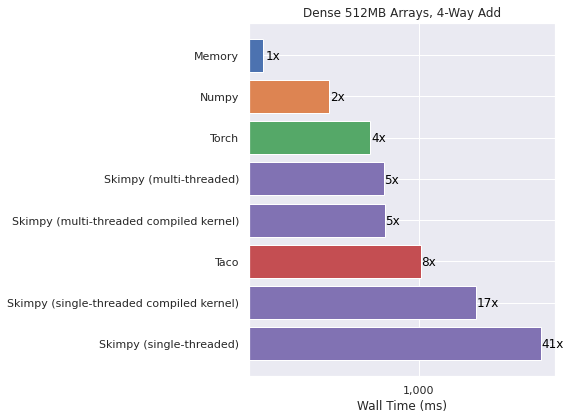

In [5]:
plot_bar(gigabyte_array_4, title="Dense 512MB Arrays, 4-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_4_way_add.png")

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


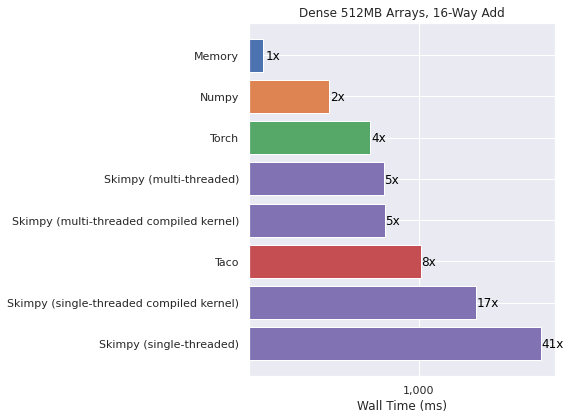

In [8]:
plot_bar(gigabyte_array_4, title="Dense 512MB Arrays, 16-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_4_way_add.png")

In [13]:
def dense_suite_num_inputs(num_inputs, array_length):
    return benchmarks.DenseArrayBenchmark.run_suite_axis(
        'num_inputs', num_inputs,
        repeats=NUM_REPEATS,
        suite=FULL_SUITE,
        array_length=array_length,
    )

In [15]:
num_inputs = np.arange(1, 32)
array_length_vals = dense_suite_num_inputs(num_inputs=num_inputs, array_length=(10*MEGABYTES // BYTES_PER_INT))

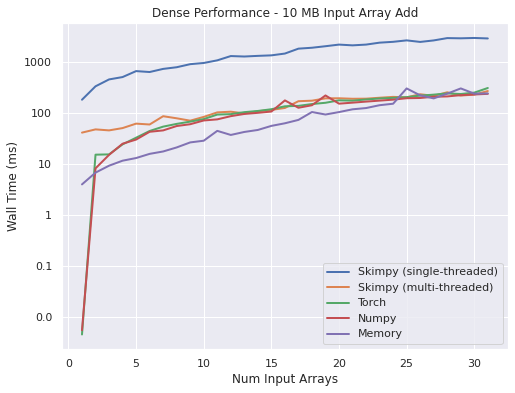

In [23]:
line_plot(
    num_inputs, 
    array_length_vals, 
    xlabel="Num Input Arrays", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 10 MB Input Array Add",
    xlog=False,
)

# Purely Sparse Benchmark Performance
This represents some number of non-zero elements per array.

Notes:
- Numpy represents dense
- Taco compile grows exponentially in number of sources (hence limiting to 8)
- Taco JIT compile time is not included, but can be significant

In [4]:
def pure_sparse_suite(num_non_zeros, num_inputs, suite=SPARSE_SUITE):
    return benchmarks.RunLengthArrayBenchmark.run_suite_axis(
        'num_non_zero', num_non_zeros,
        repeats=NUM_REPEATS,
        array_length=256 * MEGABYTES,
        num_inputs=num_inputs,
        align_inputs=False,
        deterministic_run_length=True,
        run_length=1,
        suite=suite,
    )

In [5]:
num_non_zeros = log_2_elements_space(256, 10_000_000, num=2)
four_way_sparse = pure_sparse_suite(num_non_zeros, num_inputs=4)
eight_way_sparse = pure_sparse_suite(num_non_zeros, num_inputs=8, suite=SPARSE_SUITE_NO_TACO)

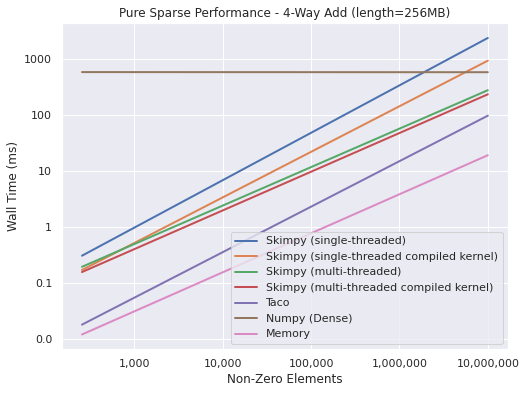

In [6]:
line_plot(
    num_non_zeros, 
    four_way_sparse, 
    xlabel="Non-Zero Elements", 
    ylabel="Wall Time (ms)",
    title="Pure Sparse Performance - 4-Way Add (length=256MB)",
)

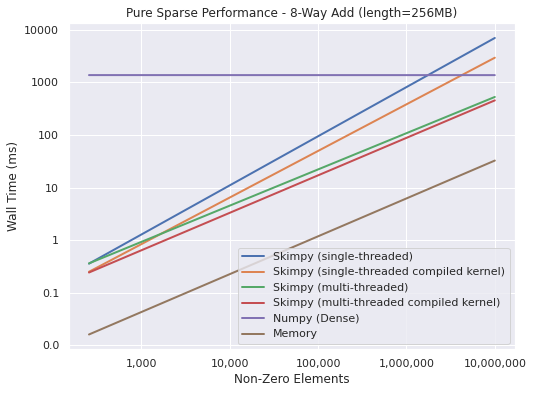

In [7]:
line_plot(
    num_non_zeros, 
    eight_way_sparse, 
    xlabel="Non-Zero Elements", 
    ylabel="Wall Time (ms)",
    title="Pure Sparse Performance - 8-Way Add (length=256MB)",
)

In [10]:
density_10 = benchmarks.RunLengthArrayBenchmark.run_suite(
    repeats=1,
    num_non_zero=51 * MEGABYTES // 4,
    array_length=512 * MEGABYTES // 4,
    num_inputs=4,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
    suite=SPARSE_SUITE,
)

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [11]:
density_50 = benchmarks.RunLengthArrayBenchmark.run_suite(
    repeats=1,
    num_non_zero=256 * MEGABYTES // 4,
    array_length=512 * MEGABYTES // 4,
    num_inputs=4,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
    suite=SPARSE_SUITE,
)

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


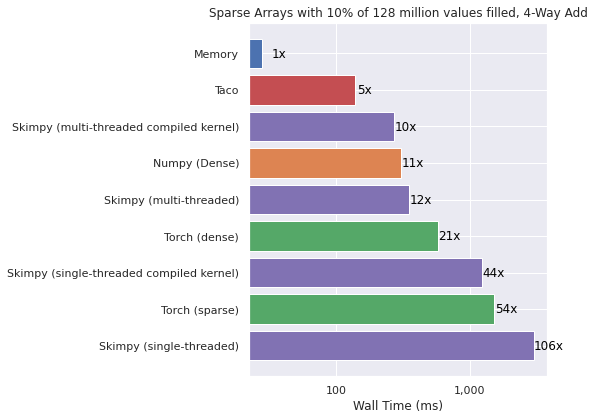

In [13]:
plot_bar(density_10, title="Sparse Arrays with 10% of 128 million values filled, 4-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/sparse_4_way_add_density_10.png")

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


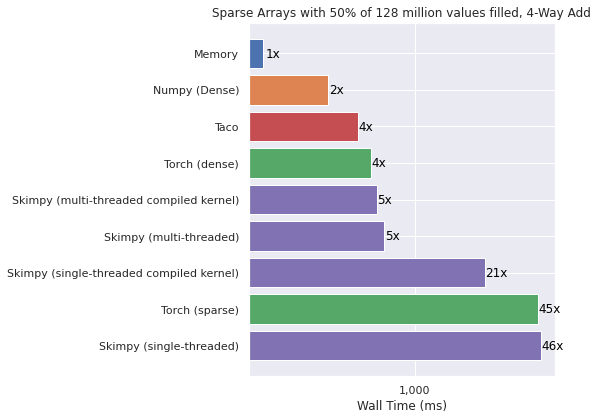

In [14]:
plot_bar(density_50, title="Sparse Arrays with 50% of 128 million values filled, 4-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/sparse_4_way_add_density_50.png")

# Run Length Benchmark Performance
This is a synthetic suite where we add together run-length encoded arrays. Each input contains N runs of length 100.

Notes:
- Numpy is represented in dense format
- Taco does not benefit from the run length encoding and represents things in sparse format
- Taco compile grows exponentially in number of sources (hence limiting to 8)
- Taco JIT compile time is not included, but can be significant

In [9]:
def heavy_runs_suite(num_non_zeros, num_inputs, suite=SPARSE_SUITE):
    return benchmarks.RunLengthArrayBenchmark.run_suite_axis(
        'num_non_zero', num_non_zeros,
        repeats=NUM_REPEATS,
        array_length=256 * MEGABYTES,
        num_inputs=num_inputs,
        align_inputs=False,
        deterministic_run_length=True,
        run_length=100,
        suite=suite,
    )

In [11]:
num_non_zeros = log_2_elements_space(256, 10_000_000, num=5)
four_way_heavy_runs = heavy_runs_suite(num_non_zeros, num_inputs=4)
eight_way_heavy_runs = heavy_runs_suite(num_non_zeros, num_inputs=8, suite=SPARSE_SUITE_NO_TACO)

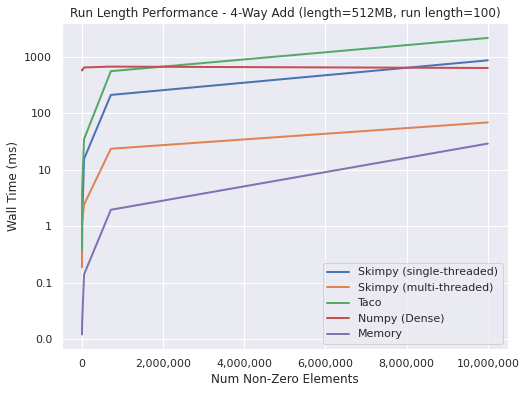

In [12]:
line_plot(
    num_non_zeros, 
    four_way_heavy_runs, 
    xlabel="Num 100-Length Runs", 
    ylabel="Wall Time (ms)",
    title="Run Length Performance - 4-Way Add (length=256MB)",
    xlog=False,
)

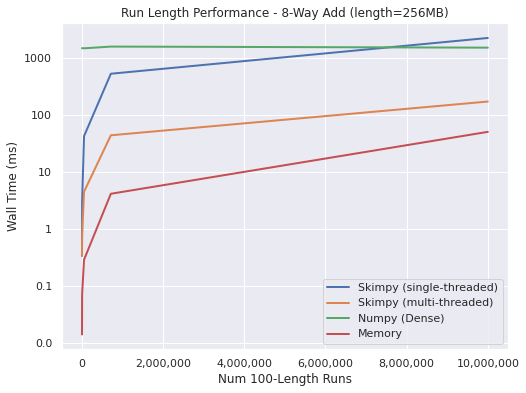

In [15]:
line_plot(
    num_non_zeros, 
    eight_way_heavy_runs, 
    xlabel="Num 100-Length Runs", 
    ylabel="Wall Time (ms)",
    title="Run Length Performance - 8-Way Add (length=256MB)",
    xlog=False,
)

In [19]:
run_length = 10
run_length_density_10 = benchmarks.RunLengthArrayBenchmark.run_suite(
    num_non_zero=int(0.1 * 512 * MEGABYTES // (4 * run_length)),
    repeats=NUM_REPEATS,
    array_length=512 * MEGABYTES,
    num_inputs=4,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=run_length,
    suite=SPARSE_SUITE,
)

In [20]:
run_length_density_50 = benchmarks.RunLengthArrayBenchmark.run_suite(
    num_non_zero=int(0.5 * 512 * MEGABYTES // (4 * run_length)),
    repeats=NUM_REPEATS,
    array_length=512 * MEGABYTES,
    num_inputs=4,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=run_length,
    suite=SPARSE_SUITE,
)

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


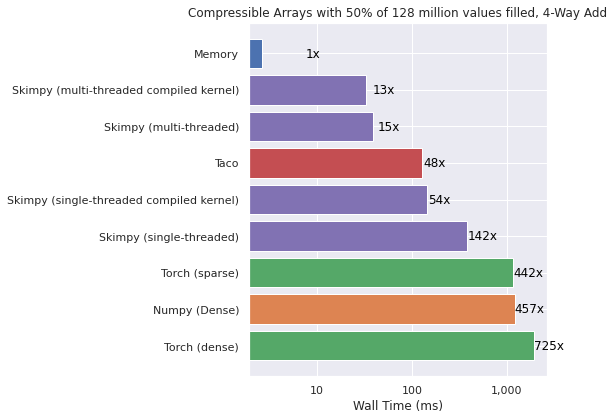

In [21]:
plot_bar(run_length_density_10, title="Compressible Arrays with 50% of 128 million values filled, 4-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/compressible_4_way_add_density_10.png")

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


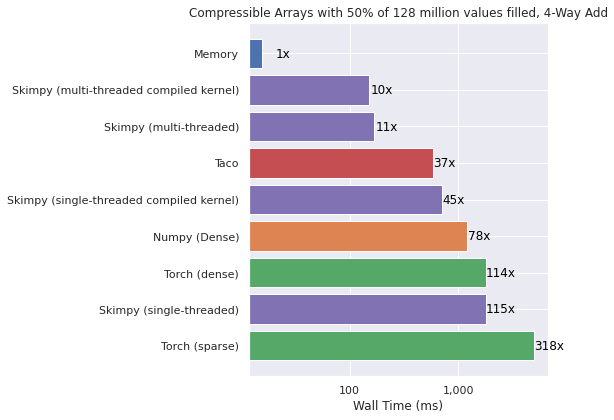

In [22]:
plot_bar(run_length_density_50, title="Compressible Arrays with 50% of 128 million values filled, 4-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/compressible_4_way_add_density_50.png")

# Convolution Performance
Notes:
- Torch is dense
- GPU time includes the output copy from GPU memory to CPU memory
- Torch uses multiple cores for computation on CPU

In [19]:
def dense_conv_suite(width, kernel_width):
    return benchmarks.Dense3DConvolutionBenchmark.run_suite_axis(
        'shape', [(e, e, e) for e in width],
        kernel_width=kernel_width,
        suite=CONV_SUITE_WITH_GPU,
        repeats=NUM_REPEATS,
    )

In [39]:
width = np.array([8, 16, 64, 128, 256, 512]).astype(int)
kernel_3_suite = dense_conv_suite(width, kernel_width=3)

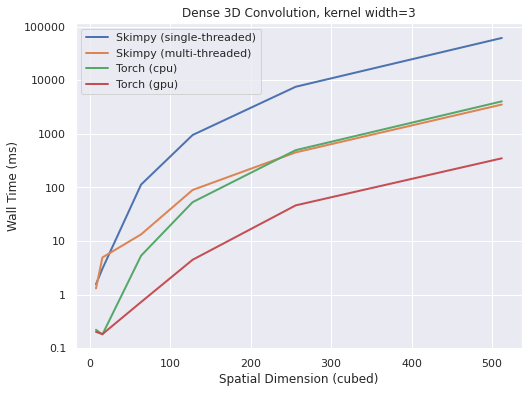

In [40]:
line_plot(
    width, 
    kernel_3_suite, 
    xlabel="Spatial Dimension (cubed)", 
    ylabel="Wall Time (ms)",
    title="Dense 3D Convolution, kernel width=3",
    xlog=False,
)

In [27]:
def run_length_conv_suite(num_non_zeros, spatial_width, kernel_width):
    return benchmarks.RunLength3DConvolutionBenchmark.run_suite_axis(
        'num_non_zero', num_non_zeros, 
        run_length=100,
        align_inputs=False,
        deterministic_run_length=True,
        shape=(spatial_width, spatial_width, spatial_width),
        kernel_width=kernel_width,
        suite=CONV_SUITE_WITH_GPU,
        repeats=NUM_REPEATS,
    )

In [37]:
num_non_zeros = log_2_elements_space(1000, 10_000_000, num=20)
kernel_run_length_suite = run_length_conv_suite(num_non_zeros, spatial_width=256, kernel_width=3)

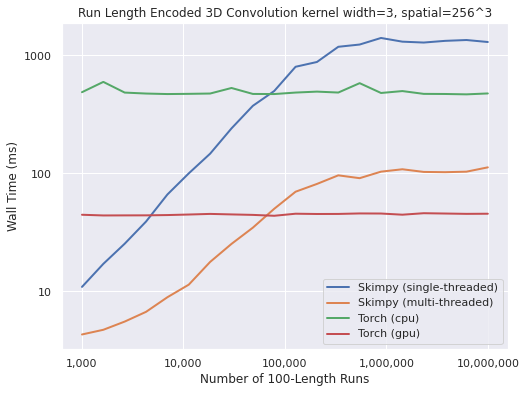

In [38]:
line_plot(
    num_non_zeros, 
    kernel_run_length_suite, 
    xlabel="Number of 100-Length Runs", 
    ylabel="Wall Time (ms)",
    title="Run Length Encoded 3D Convolution kernel width=3, spatial=256^3",
    xlog=True,
)

In [4]:
rl = benchmarks.RunLengthArrayBenchmark(
    num_non_zero=50_000_000,
    array_length=512 * MEGABYTES,
    num_inputs=4,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
)

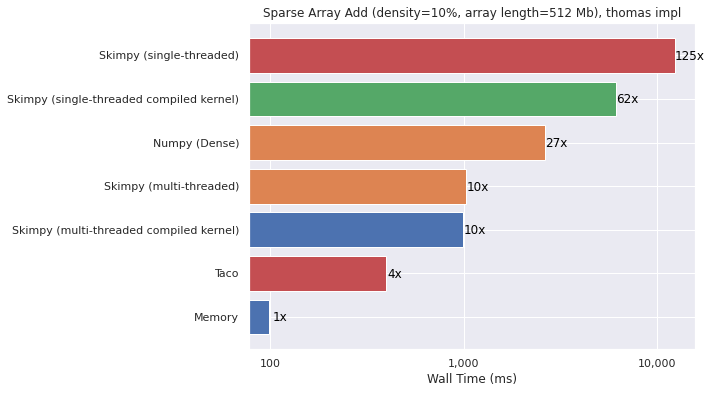

In [66]:
plot_bar(ret, title="Sparse Array Add (density=10%, array length=512 Mb), thomas impl", xlabel="Wall Time (ms)")

In [4]:
ret_tournament = benchmarks.RunLengthArrayBenchmark.run_suite(
    repeats=1,
    num_non_zero=50_000_000,
    array_length=512 * MEGABYTES,
    num_inputs=4,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
    suite=SPARSE_SUITE,
)

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


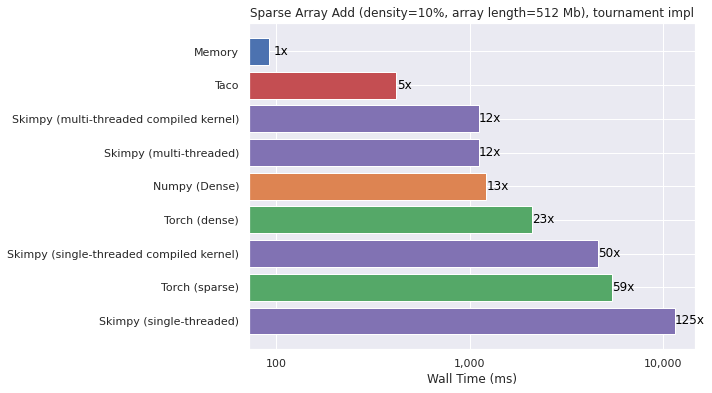

In [9]:
plot_bar(ret_tournament, title="Sparse Array Add (density=10%, array length=512 Mb), tournament impl", xlabel="Wall Time (ms)")